In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy
import matplotlib.pyplot as plt

In [2]:
def plot_moonpass(file, start, offset = 0):
    noise = np.fromfile(file, 'float32')
    
    # Time to sweep
    t_start = Time(start)
    t_step = 1*u.s
    t = t_start + np.arange(noise.size)*t_step

    # Observer location
    ea4gpz = EarthLocation(lat = 40.595865*u.deg, lon = -3.699069*u.deg, height=800*u.m)

    # Antenna pointing
    azimuth = 137.64*u.deg
    elevation = 33.63*u.deg
    
    dish_pointing = SkyCoord(AltAz(az = azimuth * np.ones(t.size), alt = elevation*np.ones(t.size),\
                               location = ea4gpz, obstime = t))
    moon = astropy.coordinates.get_moon(t)
    separation = moon.separation(dish_pointing)
    
    fig, ax = plt.subplots(figsize = (12,7), facecolor = 'w')
    ax2 = ax.twinx()
    nn = 10*np.log10(noise[1:])
    nn -= np.average(nn)
    nn += offset
    ax.plot(t.datetime[1:], nn, color = 'C0')
    ax2.plot(t.datetime, separation, color = 'C1')
    ax.set_title('Moon noise at 10366.5MHz (1MHz BW)')
    ax.set_xlabel('UTC time')
    ax.set_ylabel('Noise (dB)', color = 'C0')
    ax.grid()
    ax2.set_ylabel('Moon separation from dish (deg)', color = 'C1');

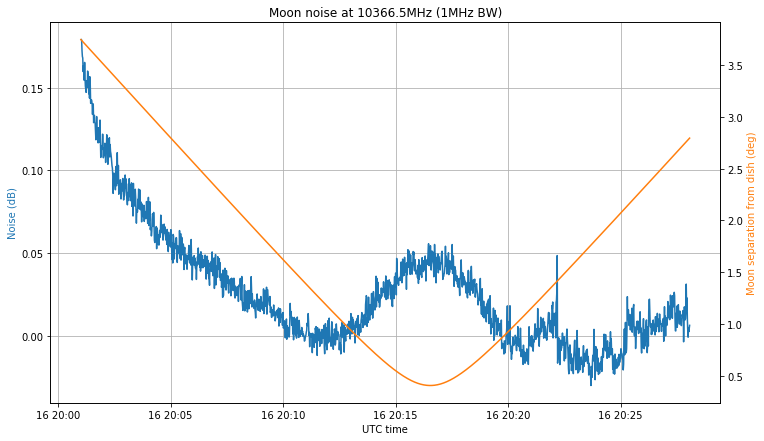

In [3]:
plot_moonpass('moon_power.f32', '2019-05-16 20:01:00.638605', offset = 0.027)

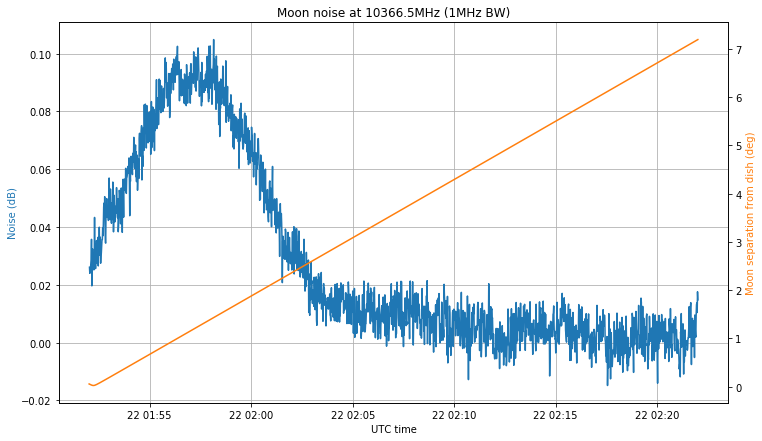

In [4]:
plot_moonpass('moon_power_2.f32', '2019-07-22T01:52:01.00927', offset = 0.027)

In [5]:
y_factor = np.fromfile('y_power_2019-05-19T11:08:39.981058.f32', 'float32')

In [6]:
def plot_y_factor(y, cold, hot, freq):
    plt.figure(figsize = (12,6), facecolor = 'w')
    plt.plot(10*np.log10(y), color = 'grey')
    plt.plot(cold, 10*np.log10(y[cold]), color = 'blue')
    plt.plot(hot, 10*np.log10(y[hot]), color = 'red')
    plt.grid()
    plt.title(f'{freq*1e-6}MHz')
    return 10*np.log10(np.average(y[hot])) - 10*np.log10(np.average(y[cold]))

2.4789440631866455


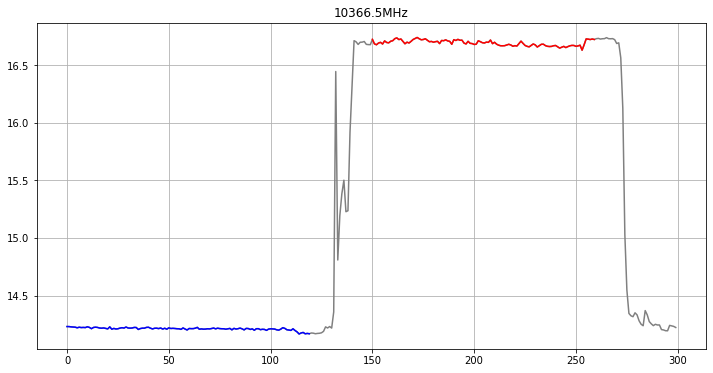

In [7]:
print(plot_y_factor(y_factor[100:400], np.arange(0,120), np.arange(150,260), 10366.5e6))

3.004046678543091


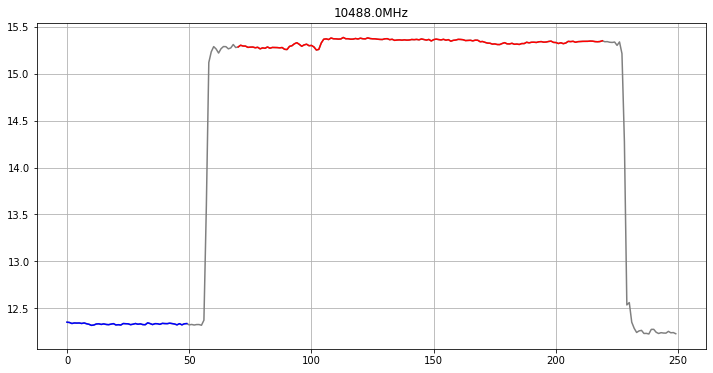

In [8]:
print(plot_y_factor(y_factor[600:850], np.arange(0,50), np.arange(70,220), 10488e6))

3.4177660942077637


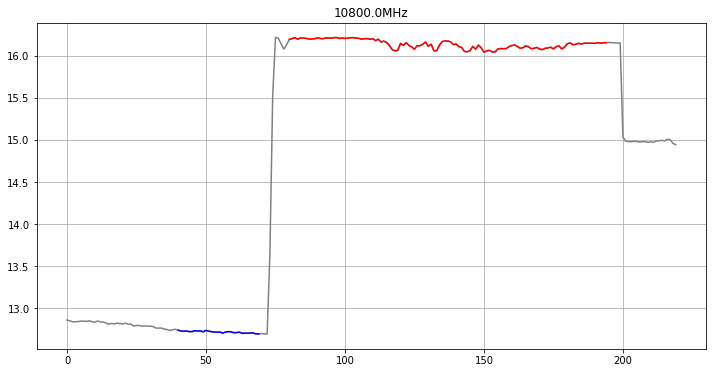

In [9]:
print(plot_y_factor(y_factor[950:1170], np.arange(40,70), np.arange(80,195), 10800e6))

In [10]:
t_hot = 290
t_cold = 70
for Y in [2.48, 3, 3.4]:
    t_sys = (t_hot - 10**(Y/10)*t_cold)/(10**(Y/10)-1)
    nf = 10*np.log10(t_sys/297+1)
    print(t_sys, nf)

215.67386163208496 2.3708472644515384
151.04725225819396 1.7856736895064715
115.22235065017054 1.4237508616305459


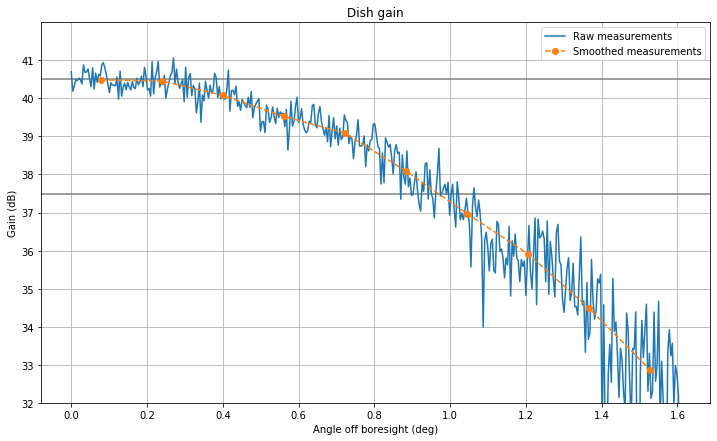

In [11]:
file = 'moon_power_2.f32'
start = '2019-07-22T01:52:01.00927'
noise = np.fromfile(file, 'float32')
offset = 0.027
sel = slice(300,700)
    
# Time to sweep
t_start = Time(start)
t_step = 1*u.s
t = t_start + np.arange(noise.size)*t_step

# Observer location
ea4gpz = EarthLocation(lat = 40.595865*u.deg, lon = -3.699069*u.deg, height=800*u.m)

# Antenna pointing
azimuth = 137.64*u.deg
elevation = 33.63*u.deg
    
dish_pointing = SkyCoord(AltAz(az = azimuth * np.ones(t.size), alt = elevation*np.ones(t.size),\
                                   location = ea4gpz, obstime = t))
moon = astropy.coordinates.get_moon(t)
separation = moon.separation(dish_pointing)

plt.figure(figsize = (12,7), facecolor = 'w')
nn = 10*np.log10(noise[1:])
nn -= np.average(nn)
nn += offset
nn = nn[sel]
theta = (separation[sel]-separation[sel][0])
gain = 10**(nn/10)-1
gain_average = np.trapz(gain * 2 * np.pi * np.sin(theta), x = theta.rad)/(4*np.pi)
normalized_gain = gain/gain_average
plt.axhline(40.5, color = 'grey')
plt.axhline(40.5-3, color = 'grey')
plt.plot(theta, 10*np.log10(normalized_gain), label = 'Raw measurements')
plt.plot(np.average(theta.reshape((-1,40)), axis = 1),
           10*np.log10(np.average(normalized_gain.reshape((-1,40)), axis = 1)), 'o--', label = 'Smoothed measurements')
plt.grid()
plt.yticks(np.arange(32,42))
plt.ylim((32,42))
plt.ylabel('Gain (dB)')
plt.xlabel('Angle off boresight (deg)')
plt.title('Dish gain')
plt.legend();